In [2]:
import nltk 
import re
import pandas as pd
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
#from nltk.stem import PorsterStemmer
from nltk.stem import SnowballStemmer
from nltk.stem import WordNetLemmatizer
import spacy
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from wordcloud import WordCloud
from datetime import datetime
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer, TfidfVectorizer



In [3]:
data1=pd.read_csv('./dfhotelsbcnwithdescrmay.csv')
data2=pd.read_csv('./dfhotelsbcnwithdescrjune.csv')
data3=pd.read_csv('./dfhotelsvalwithdescrmay.csv')
data4=pd.read_csv('./dfhotelsvalwithdescrjune.csv')
combined_data = pd.concat([data1, data2, data3, data4], ignore_index=True)
print(combined_data)

           City              Date Period  \
0     Barcelona  2025-05-21 : 2025-05-25   
1     Barcelona  2025-05-21 : 2025-05-25   
2     Barcelona  2025-05-21 : 2025-05-25   
3     Barcelona  2025-05-21 : 2025-05-25   
4     Barcelona  2025-05-21 : 2025-05-25   
...         ...                      ...   
3875   Valencia  2025-06-04 : 2025-06-08   
3876   Valencia  2025-06-04 : 2025-06-08   
3877   Valencia  2025-06-04 : 2025-06-08   
3878   Valencia  2025-06-04 : 2025-06-08   
3879   Valencia  2025-06-04 : 2025-06-08   

                                               Hotel  Prices  Ratings  \
0                            Be Mate Paseo de Gracia  1443.0      8.9   
1                                 Hotel La Pau 4 Sup  2568.0      9.6   
2          Four Points by Sheraton Barcelona Airport   531.0      8.7   
3                                    Tembo Barcelona  1707.0      8.8   
4             Axel TWO Barcelona 4 Sup - Adults Only   976.0      8.3   
...                              

### Data Cleaning & Preprocessing

In [4]:
# Count the number of duplicates
num_duplicates = combined_data.shape[0] - combined_data.drop_duplicates().shape[0]

print(f"Number of duplicate rows: {num_duplicates}")


Number of duplicate rows: 0


In [5]:
combined_data['Prices'] = pd.to_numeric(combined_data['Prices'], errors='coerce')
combined_data['Ratings'] = pd.to_numeric(combined_data['Ratings'], errors='coerce')

Inpute missing values based on hotel rating.

In [6]:
combined_data['Ratings'] = combined_data['Ratings'].fillna(combined_data['Ratings'].median())


In [7]:
# Count total missing values in each column
missing_counts = combined_data.isna().sum()
print(missing_counts)

City           0
Date Period    0
Hotel          0
Prices         0
Ratings        0
Description    0
dtype: int64


In [8]:
# Summary statistics for Prices and Ratings
print(combined_data[['Prices', 'Ratings']].describe())

# Group by city and date
city_prices = combined_data.groupby(['City', 'Date Period'])['Prices'].mean().reset_index()


             Prices      Ratings
count   3880.000000  3880.000000
mean    1332.909794     8.253789
std     1204.417659     0.977178
min      156.000000     1.000000
25%      684.000000     8.000000
50%     1019.000000     8.400000
75%     1496.500000     8.800000
max    17335.000000    10.000000


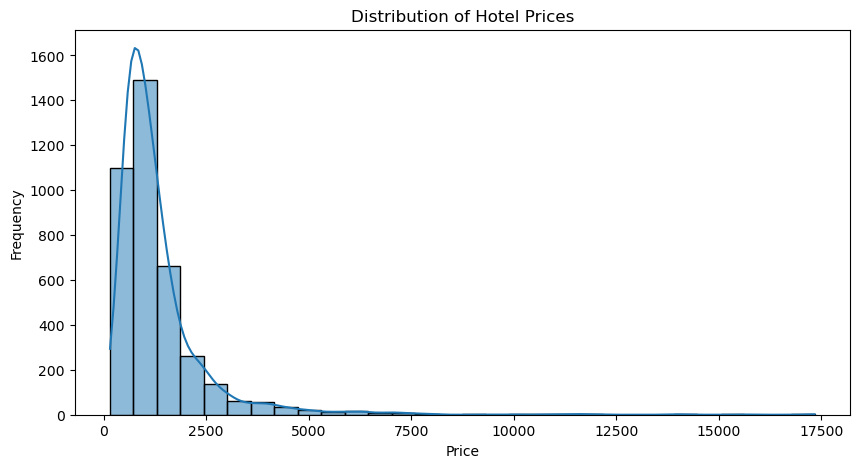

In [9]:
plt.figure(figsize=(10,5))
sns.histplot(combined_data['Prices'], bins=30, kde=True)
plt.title('Distribution of Hotel Prices')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()


In [10]:
# Create dummy for 'is_bcn' (1 if city is Barcelona, 0 otherwise)
combined_data['Treatment'] = (combined_data['City'] == 'Barcelona').astype(int)

# Create dummy for 'is_june' (1 if the Date Period contains "06-", meaning June)
combined_data['Time_Period'] = combined_data['Date Period'].apply(lambda x: '06-' in x).astype(int)



In [11]:
combined_data.drop(columns=['City', 'Date Period'], inplace=True)
combined_data

,Hotel,Prices,Ratings,Description,Treatment,Time_Period
0,Be Mate Paseo de Gracia,1443.0,8.9,"El Be Mate Paseo de Gracia, situado en Barcelo...",1,0
1,Hotel La Pau 4 Sup,2568.0,9.6,El Hotel La Pau 4 Sup está situado en el centr...,1,0
2,Four Points by Sheraton Barcelona Airport,531.0,8.7,Four Points by Sheraton Barcelona Airport está...,1,0
3,Tembo Barcelona,1707.0,8.8,"Tembo Barcelona está en Barcelona, a 16 min a ...",1,0
4,Axel TWO Barcelona 4 Sup - Adults Only,976.0,8.3,El TWO Hotel Barcelona by Axel está situado en...,1,0
...,...,...,...,...,...,...
3875,NEW Beach Flats Valencia 3,895.0,10.0,NEW Beach Flats Valencia 3 se encuentra en Val...,0,1
3876,L'Otelet By Sweet,390.0,7.7,"L'Otelet By Sweet está en Valencia, a 5,5 km d...",0,1
3877,Apartamento Cienciasmar,536.0,3.9,Apartamento Cienciasmar está en Valencia y ofr...,0,1
3878,Pelayo with terrace Mid-term,1250.0,6.6,"Pelayo with terrace Mid-term está en Valencia,...",0,1


This code tokenizes (splits) text from the "Hotel" and "Description" columns in combined_data, then builds a vocabulary where each unique word gets assigned a unique index.

In [12]:
# Tokenize function (split text into words)
def tokenize(text):
    return text.split() if isinstance(text, str) else []

# Build vocabulary for both 'Hotel' and 'Description'
vocab_combined, index = {}, 1

for column in ['Hotel', 'Description']:
    for doc in combined_data[column].dropna():
        tokens = tokenize(doc)
        for token in tokens:
            if token not in vocab_combined:
                vocab_combined[token] = index
                index += 1


The fucntion below converts a list of tokens (words) into a bag-of-words (BoW) vector using a given vocabulary (vocab).

In [13]:
def vectorize(token_list, vocab):
    """
    Convert a list of tokens into a bag-of-words vector using the provided vocabulary.

    Each token in the vocabulary is represented by its unique index (starting from 1).
    The output vector is a list of counts where the position (index - 1) corresponds 
    to the token's count from the token_list.

    Args:
        token_list (List[str]): A list of tokens representing a document.
        vocab (dict): A dictionary mapping tokens to a unique index (starting at 1).

    Returns:
        List[int]: A vector (list of integers) representing token counts.
    """
    # Initialize a vector of zeros with length equal to the number of unique tokens in vocab.
    vec = [0] * len(vocab)
    
    # Count tokens by incrementing the appropriate index in the vector.
    for token in token_list:
        token_index = vocab.get(token)
        if token_index is not None:
            # Adjust for 0-indexed Python lists (our vocab indices start at 1)
            vec[token_index - 1] += 1  # <-- This was missing

    return vec

In [14]:
# Convert each document into a vector
vectors_combined = [vectorize(tokenize(doc), vocab_combined) for doc in combined_data['Hotel'].fillna('')]
vectors_desc = [vectorize(tokenize(doc), vocab_combined) for doc in combined_data['Description'].fillna('')]

# Create a single DTM by merging both matrices
dtm_combined = pd.DataFrame(vectors_combined, columns=list(vocab_combined.keys()))
dtm_desc_df = pd.DataFrame(vectors_desc, columns=list(vocab_combined.keys()))
dtm_final = dtm_combined.add(dtm_desc_df, fill_value=0).astype(int)

dtm_final


,Be,Mate,Paseo,de,Gracia,Hotel,La,Pau,4,Sup,...,"SelfCheckIn,","Suite,","Unique,",verde,lecho,extiende,puentes,cruzaban,todavía,lugar.
0,2,2,3,14,2,0,2,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,12,0,3,5,3,3,3,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,14,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,10,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,17,0,2,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3875,0,0,0,15,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3876,0,0,0,16,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3877,0,0,0,15,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3878,0,0,0,10,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [15]:
# Merge with city data
dtm_final.index = combined_data.index
dtm_final = combined_data[['Treatment']].join(dtm_final)
dtm_final['City'] = dtm_final['Treatment'].map({1: 'Barcelona', 0: 'Valencia'})
dtm_final

,Treatment,Be,Mate,Paseo,de,Gracia,Hotel,La,Pau,4,...,"SelfCheckIn,","Suite,","Unique,",verde,lecho,extiende,puentes,cruzaban,todavía,lugar.
0,1,2,2,3,14,2,0,2,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,12,0,3,5,3,3,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,14,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,10,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,17,0,2,0,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3875,0,0,0,0,15,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3876,0,0,0,0,16,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3877,0,0,0,0,15,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3878,0,0,0,0,10,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [16]:
# Convert DTM to text format grouped by City
dtm_text_by_city = {
    city: [" ".join([word for word, count in zip(dtm_final.columns, row) if count > 0]) 
           for row in dtm_final[dtm_final['City'] == city].drop(columns=['Treatment', 'City']).values]
    for city in dtm_final['City'].unique()
}

In [17]:
dtm_text_by_city

{'Barcelona': ['Treatment Be Mate Paseo de Hotel Sheraton Only Group acogedor Marriott BUHO Labtwentytwo Blu Triunfo Cosi Alguer Vinoteca Piso VIII Leevin st Bonito 2-bd Style Vela Yate Mirador Seaside Min, Elegante RealRent Caroline Cienciasmar Gracia, situado 600 Pedrera, menos km Batlló, unos pie Tivoli, ofrece jardín, terraza, conexión gratuita, servicio enlace aeropuerto alquiler bicicletas. hotel incluyen armario, pantalla plana, hervidor agua privado. Algunas cuentan balcón, otras disponen jardín. se encuentra 2,1 Prat queda',
  'Paseo Gracia Hotel La Pau 4 B Group acogedor city Marriott #htopEnjoy BUHO Labtwentytwo and Blu Trafalgar Triunfo Alguer Silver Vinoteca tranquila ideal Click&Flat st Hermoso Bonito Style Serrano Yate Mirador espaciosos Seaside Orense open-air Unique Cienciasmar Batlló, servicio hervidor balcón, encuentra 16 establecimiento. está famosa 350 metros. establecimiento cuenta recepción abierta 24 horas guardaequipaje. Hay gratuita recepción. Todas 800 Seu, c

{'abierta': 691.1527974227967, 'acondicionado': 774.795895872665, 'aeropuerto': 966.5910358042637, 'agua': 567.2094204283999, 'air': 529.2084125374602, 'airport': 1261.9764359638018, 'alberga': 620.9604194701279, 'albergue': 712.8073735279662, 'almohadas': 434.4702272173811, 'alojamientos': 539.4846170580978, 'alquiler': 1208.4645232974494, 'aparcamiento': 584.0158085831364, 'apartamentos': 841.6410319871695, 'aparteasy': 915.0277179193674, 'apartments': 1247.3692076656343, 'armario': 761.3801176559244, 'artista': 594.1913557550481, 'asimismo': 601.4274632853122, 'atractiva': 497.7189140276773, 'bajo': 555.6992388300321, 'balneario': 492.370141983371, 'bar': 1381.5975046375006, 'barbacoa': 532.7841450546051, 'barcelona': 1283.8692063562733, 'barceloneta': 605.8281781119568, 'bares': 962.1586561982907, 'bcn': 985.8483737403556, 'bdrm': 425.71634839559397, 'beach': 445.65232123910164, 'bear': 949.8892383438457, 'bet': 608.6127225284328, 'bicicleta': 476.1429015972831, 'bicicletas': 943.2

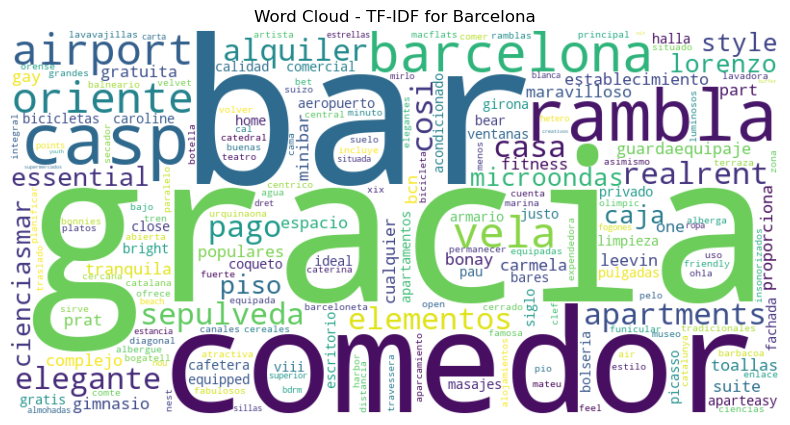

{'acondicionado': 396.70417810910584, 'aeropuerto': 1281.5114146030899, 'agua': 395.6991445237562, 'albufera': 723.8938401972296, 'alma': 962.3821222414022, 'alojamiento': 631.1912555067936, 'alojamientos': 638.0974420964103, 'alquiler': 574.1790078543413, 'apartamento': 437.98571561371847, 'aparteasy': 406.45293323108444, 'apartments': 824.4320322372324, 'armario': 826.3469760717896, 'artista': 409.36586639692746, 'asimismo': 706.8659921895099, 'ayuntamiento': 640.0974598102296, 'balneario': 549.4319559171932, 'barbacoa': 490.0228382734884, 'barcelona': 695.3713744237556, 'bear': 709.0098247062011, 'bicicletas': 841.343578935435, 'blue': 446.3985002974676, 'bogatell': 777.3833200544199, 'bonay': 746.860434646144, 'bonito': 881.3949919345558, 'botella': 574.1790078543413, 'buenas': 495.3365759340649, 'cafetera': 936.2028710051839, 'caja': 1146.8086257612122, 'cal': 783.3819909505461, 'cama': 533.732298792028, 'carmela': 541.8854232031856, 'catalunya': 610.1869370659299, 'caterina': 114

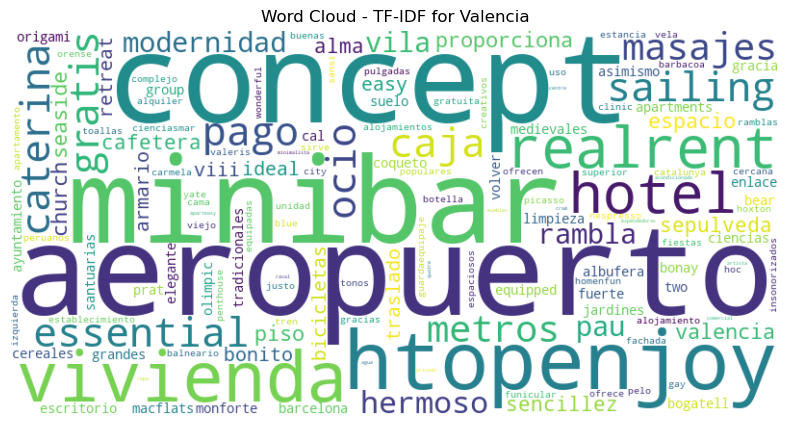

In [18]:
# Load English and Spanish stopwords
english_stopwords = set(stopwords.words('english'))
spanish_stopwords = set(stopwords.words('spanish'))

# Combine both sets
custom_stopwords = list(english_stopwords.union(spanish_stopwords))
def generate_wordcloud_tfidf(text_data, city_name):
    """
    Generates a TF-IDF-based word cloud for the given city.
    
    Args:
        text_data (list): List of processed text documents for the city.
        city_name (str): City name (Barcelona/Valencia).
    """
    
    # Initialize TF-IDF Vectorizer
    vectorizer = TfidfVectorizer(
        norm=None, 
        min_df=0.05, 
        max_df=0.3, 
        stop_words=custom_stopwords, 
        token_pattern=r'\b[a-zA-Z]{3,}\b', 
        sublinear_tf=False
    )

    # Fit and transform the text data
    X_tfidf = vectorizer.fit_transform(text_data)
    
    # Extract term frequencies
    tfidf_sum = np.asarray(X_tfidf.sum(axis=0)).ravel()
    features = vectorizer.get_feature_names_out()
    freq_dict_tfidf = dict(zip(features, tfidf_sum))
    print(freq_dict_tfidf)
    # Generate Word Cloud
    wordcloud = WordCloud(width=800, height=400, background_color="white").generate_from_frequencies(freq_dict_tfidf)
    
    # Plot Word Cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Word Cloud - TF-IDF for {city_name}")
    plt.show()

# Generate TF-IDF Word Clouds for Barcelona and Valencia
for city in dtm_text_by_city.keys():
    generate_wordcloud_tfidf(dtm_text_by_city[city], city)


These word clouds visualize the most distinctive words in hotel descriptions for Barcelona and Valencia, based on TF-IDF scores, before any preprocessing. 
The TF-IDF model helps us identify key differences in how hotels describe their accommodations in different cities. TF-IDF reduces the influence of common words and highlights unique words that appear more frequently in one city's descriptions but not the other. Thus, it allows us to observe clear regional trends.

#### Word Cloud for Barcelona
The word cloud for Barcelona highlights key terms such as "barcelona," "comedor," and "apartments," indicating a strong emphasis on accommodations and dining. Words like "elegante" and "proporcional" suggest that descriptions focus on comfort and stylish stays. Additionally, the presence of "aeropuerto" and "orientación" implies that transportation and location convenience are essential features.

#### Word Cloud for Valencia
In Valencia, the word cloud emphasizes terms such as "vivienda," "minibar," and "concept," indicating a focus on modern and well-equipped accommodations. The frequent appearance of "masajes" and "sailing" suggests that wellness and coastal activities play a significant role in the hotel descriptions. The presence of "catering" and "propiedad" also implies a focus on food services and property-related details.


## Text analysis

In [19]:
# Create a set of stopwords for both English and Spanish
STOP_WORDS = set(stopwords.words('english')) | set(stopwords.words('spanish'))

stemmer = SnowballStemmer("spanish")

def preprocess_text(text):
    """
    Preprocess text by:
    - Converting to lowercase
    - Removing punctuation
    - Tokenizing
    - Removing stopwords (English & Spanish)
    - Applying stemming
    
    Returns:
        str: A cleaned and stemmed text string.
    """
    if not isinstance(text, str):  # Handle NaN or non-string cases
        return ""

    text = text.lower()  # Convert to lowercase
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    tokens = word_tokenize(text)  # Tokenize text
    filtered_tokens = [stemmer.stem(token) for token in tokens if token not in STOP_WORDS]  # Remove stopwords & stem

    return " ".join(filtered_tokens)


In [20]:
# Apply the function to the 'Description' column and create a new column
combined_data['Cleaned_Description'] = combined_data['Description'].apply(preprocess_text)
print(combined_data['Cleaned_Description'])

0       mat pase graci situ barcelon 600 metr pedrer m...
1       hotel pau 4 sup situ centr barcelon 400 metr p...
2       four points sheraton barcelon airport barcelon...
3       temb barcelon barcelon 16 min pie platj llevan...
4       two hotel barcelon axel situ plen barri gay ba...
                              ...                        
3875    new beach flats valenci 3 encuentr valenci 13 ...
3876    lotelet sweet valenci 55 km church saint nicol...
3877    apartament cienciasm valenci ofrec aloj wifi g...
3878    pelay terrac midterm valenci 16 min pie church...
3879    florit flats maritim serreri apartments valenc...
Name: Cleaned_Description, Length: 3880, dtype: object


In [21]:
combined_data.drop(columns=['Description'], inplace=True)


In [22]:
print(combined_data)

                                               Hotel  Prices  Ratings  \
0                            Be Mate Paseo de Gracia  1443.0      8.9   
1                                 Hotel La Pau 4 Sup  2568.0      9.6   
2          Four Points by Sheraton Barcelona Airport   531.0      8.7   
3                                    Tembo Barcelona  1707.0      8.8   
4             Axel TWO Barcelona 4 Sup - Adults Only   976.0      8.3   
...                                              ...     ...      ...   
3875                      NEW Beach Flats Valencia 3   895.0     10.0   
3876                               L'Otelet By Sweet   390.0      7.7   
3877                         Apartamento Cienciasmar   536.0      3.9   
3878                    Pelayo with terrace Mid-term  1250.0      6.6   
3879  FLORIT FLATS - The Maritim Serreria Apartments   929.0      9.0   

      Treatment  Time_Period  \
0             1            0   
1             1            0   
2             1            

We process the hotel name too.

In [23]:
# Apply the function to the 'Description' column and create a new column
combined_data['Clean_hotel'] = combined_data['Hotel'].apply(preprocess_text)
print(combined_data['Clean_hotel'])
combined_data.drop(columns=['Hotel'], inplace=True)


0                                mat pase graci
1                               hotel pau 4 sup
2         four points sheraton barcelon airport
3                                 temb barcelon
4                axel two barcelon 4 sup adults
                         ...                   
3875                  new beach flats valenci 3
3876                              lotelet sweet
3877                       apartament cienciasm
3878                       pelay terrac midterm
3879    florit flats maritim serreri apartments
Name: Clean_hotel, Length: 3880, dtype: object


In [24]:
combined_data

,Prices,Ratings,Treatment,Time_Period,Cleaned_Description,Clean_hotel
0,1443.0,8.9,1,0,mat pase graci situ barcelon 600 metr pedrer m...,mat pase graci
1,2568.0,9.6,1,0,hotel pau 4 sup situ centr barcelon 400 metr p...,hotel pau 4 sup
2,531.0,8.7,1,0,four points sheraton barcelon airport barcelon...,four points sheraton barcelon airport
3,1707.0,8.8,1,0,temb barcelon barcelon 16 min pie platj llevan...,temb barcelon
4,976.0,8.3,1,0,two hotel barcelon axel situ plen barri gay ba...,axel two barcelon 4 sup adults
...,...,...,...,...,...,...
3875,895.0,10.0,0,1,new beach flats valenci 3 encuentr valenci 13 ...,new beach flats valenci 3
3876,390.0,7.7,0,1,lotelet sweet valenci 55 km church saint nicol...,lotelet sweet
3877,536.0,3.9,0,1,apartament cienciasm valenci ofrec aloj wifi g...,apartament cienciasm
3878,1250.0,6.6,0,1,pelay terrac midterm valenci 16 min pie church...,pelay terrac midterm


## Vectorize and build vocabulary

In [25]:
# Tokenize function (split text into words)
def tokenize(text):
    return text.split() if isinstance(text, str) else []

# Build vocabulary for both 'Clean_hotel' and 'Cleaned_Description'
vocab_combined, index = {}, 1

for column in ['Clean_hotel', 'Cleaned_Description']:
    for doc in combined_data[column].dropna():
        tokens = tokenize(doc)
        for token in tokens:
            if token not in vocab_combined:
                vocab_combined[token] = index
                index += 1

def vectorize(token_list, vocab):
    """
    Convert a list of tokens into a bag-of-words vector using the provided vocabulary.

    Each token in the vocabulary is represented by its unique index (starting from 1).
    The output vector is a list of counts where the position (index - 1) corresponds 
    to the token's count from the token_list.

    Args:
        token_list (List[str]): A list of tokens representing a document.
        vocab (dict): A dictionary mapping tokens to a unique index (starting at 1).

    Returns:
        List[int]: A vector (list of integers) representing token counts.
    """
    # Initialize a vector of zeros with length equal to the number of unique tokens in vocab.
    vec = [0] * len(vocab)
    
    # Count tokens by incrementing the appropriate index in the vector.
    for token in token_list:
        token_index = vocab.get(token)
        if token_index is not None:
            # Adjust for 0-indexed Python lists (our vocab indices start at 1)
            vec[token_index - 1] += 1  # <-- This was missing

    return vec

In [26]:
# Convert each document into a vector
vectors_combined = [vectorize(tokenize(doc), vocab_combined) for doc in combined_data['Clean_hotel'].fillna('')]
vectors_desc = [vectorize(tokenize(doc), vocab_combined) for doc in combined_data['Cleaned_Description'].fillna('')]


In [27]:
# Create a single DTM by merging both matrices
dtm_combined = pd.DataFrame(vectors_combined, columns=list(vocab_combined.keys()))
dtm_desc_df = pd.DataFrame(vectors_desc, columns=list(vocab_combined.keys()))
dtm_final2 = dtm_combined.add(dtm_desc_df, fill_value=0).astype(int)
dtm_final2

,mat,pase,graci,hotel,pau,4,sup,four,points,sheraton,...,tailandes,verdader,tesor,restring,caract,125,1935,extiend,puent,todav
0,2,3,3,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,3,3,3,3,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,1,0,0,0,3,3,3,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,4,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3875,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3876,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3877,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3878,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [28]:
# Merge with city data
dtm_final2.index = combined_data.index
dtm_final2 = combined_data[['Treatment']].join(dtm_final2)
dtm_final2['City'] = dtm_final2['Treatment'].map({1: 'Barcelona', 0: 'Valencia'})


# Convert DTM to text format grouped by City
dtm_text_by_city2 = {
    city: [" ".join([word for word, count in zip(dtm_final2.columns, row) if count > 0]) 
           for row in dtm_final2[dtm_final2['City'] == city].drop(columns=['Treatment', 'City']).values]
    for city in dtm_final2['City'].unique()
}

In [31]:
dtm_final2

,Treatment,mat,pase,graci,hotel,pau,4,sup,four,points,...,verdader,tesor,restring,caract,125,1935,extiend,puent,todav,City
0,1,2,3,3,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Barcelona
1,1,0,0,0,3,3,3,3,0,0,...,0,0,0,0,0,0,0,0,0,Barcelona
2,1,0,0,0,1,0,0,0,3,3,...,0,0,0,0,0,0,0,0,0,Barcelona
3,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Barcelona
4,1,0,0,0,4,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,Barcelona
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3875,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,Valencia
3876,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Valencia
3877,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Valencia
3878,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Valencia


In [29]:
dtm_text_by_city2

{'Barcelona': ['Treatment mat pase graci sheraton adults min motoryacht vidreri w clot ingles francoli letamendi vinotec viii univers student 2bd alfa cos bubusuit mirador mon bien suits teo smart wc bass olimpi cienciasm 600 men km pie tivoli ofrec conexion gratuit servici enlac biciclet armari pantall plan hervidor agu cuent dispon encuentr prat qued',
  'graci hotel pau 4 sheraton nou 74 dec min vidreri nav silk clot basic balconi irla hispan letamendi lind grup alfa cos bubusuit mirador oceanografic bien suits esc scienci open men km conexion agu cuent encuentr 16 famos 350 recepcion abiert hor guardaequipaj tod 800 900 muse',
  'graci sup four points sheraton barcelon adults paralel californi feel 74 bonay dec chic pi clot erasmus clos miram algu vinotec univers bright palom alfa murill frent cos bubusuit independient lorenz mirador oceanografic 24 air smart wc men tivoli armari pantall cuent encuentr qued 350 abiert barcelonael fuent magic tempor libr fitness tren pued restaur to

{'abiert': 1021.5007307987004, 'acondicion': 1212.411873576405, 'ademas': 459.6343250616019, 'alberg': 659.82751449783, 'aleman': 972.0699079548756, 'algu': 422.83263184548696, 'allad': 1085.3726471326952, 'antib': 1177.432136794705, 'aparc': 422.83263184548696, 'aparteasy': 902.2525329574296, 'arcos': 445.65232123910164, 'articul': 1067.097547311919, 'atract': 467.92461451737216, 'bar': 470.67195881561406, 'barcelonael': 795.9864238075944, 'bass': 1216.3635724128203, 'bbarcelon': 793.9883662918236, 'bien': 1285.8740660836017, 'bonay': 1112.1644861094585, 'botan': 988.8133500821473, 'bright': 807.8963115902968, 'bubuflats': 1207.1161559762752, 'bulevar': 500.3822438968571, 'cafeter': 470.67195881561406, 'caj': 769.7131726861968, 'californi': 960.185572744646, 'canal': 932.4985566578089, 'cerc': 465.1692706377321, 'cereal': 659.82751449783, 'cienciasm': 393.4763550731338, 'circunval': 402.3848831558039, 'clas': 552.1821550399686, 'clef': 861.7705675024681, 'coctel': 961.8917227066589, '

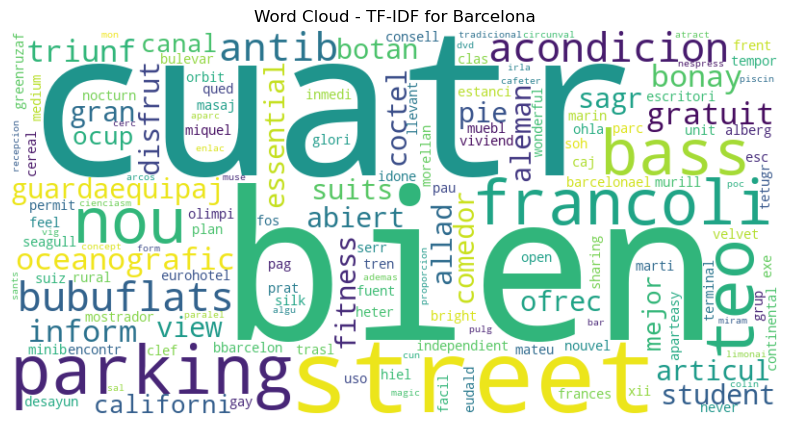

{'abiert': 492.683410641095, 'agu': 1218.7446965328443, 'aleman': 980.652345249374, 'allad': 1058.2020949681626, 'antib': 490.0228382734884, 'aparteasy': 406.45293323108444, 'articul': 1053.6256428582708, 'bar': 406.45293323108444, 'bass': 719.6630039582053, 'bien': 644.9572363046276, 'bonay': 746.860434646144, 'botan': 1062.7571184453348, 'cafeter': 490.0228382734884, 'canal': 521.4724404892487, 'carm': 682.9860510629684, 'cereal': 665.2652246198173, 'chic': 773.364925900138, 'circunval': 554.4310627427002, 'clot': 935.2043216828376, 'coctel': 415.16325323885326, 'comedor': 1248.9316897505212, 'comerci': 603.0876556800438, 'comfort': 1134.2472665703237, 'conexion': 1261.2028788559246, 'cuid': 437.98571561371847, 'cun': 516.3016159879323, 'dec': 1138.4532940722547, 'disfrut': 518.8904763800089, 'divis': 385.78783279784227, 'enjoybcn': 479.30536004318674, 'enlac': 647.23364768723, 'esc': 574.1790078543413, 'eudald': 852.791981234825, 'extramurs': 1212.3217932913751, 'gal': 955.655602402

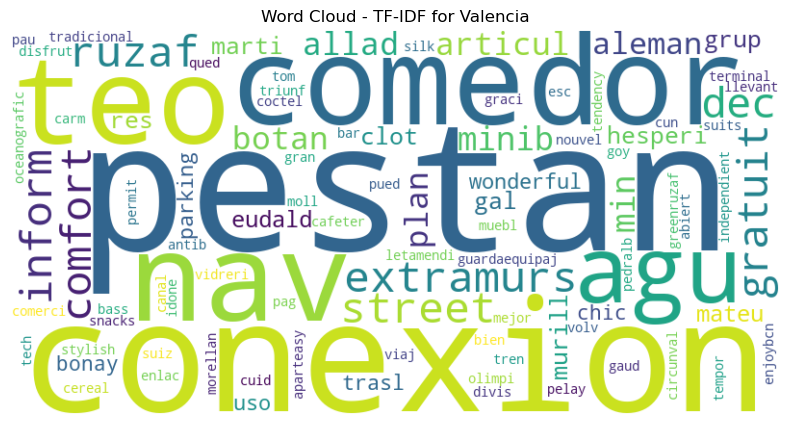

In [30]:
# Generate TF-IDF Word Clouds for Barcelona and Valencia
for city in dtm_text_by_city2.keys():
    generate_wordcloud_tfidf(dtm_text_by_city2[city], city)


### Changes in the Word Clouds After Lowercasing and Stemming  

After applying lowercasing and stemming to the text, the TF-IDF word clouds for Barcelona and Valencia have changed significantly. These changes affect both the readability of the words and the overall structure of the word clouds.

One of the most noticeable differences is that all words are now in lowercase. This might seem like a small change, but it helps standardize the text and ensures that words like "Ciudad" and "ciudad" are treated as the same word. Without lowercasing, the model might see them as different words, even though they mean the same thing. The presence of "street" and "parking" suggests that location and accessibility remain key aspects of hotel descriptions.

Another major change comes from stemming, which has shortened many words to their root forms (with words like "conex", likely from "conexión"). Stemming has caused some words that were previously separate to merge into one root form. This reduces word variety and helps emphasize the most common concepts, but it can also remove some of the subtle differences in meaning between words. 

Another interesting change is how word frequencies have shifted. Before stemming, there were more unique words in the cloud because different versions of the same word appeared separately. Now, since many words have been reduced to their root form, the word cloud looks more compact, with fewer, larger words dominating the space. 

Overall, these changes make the word clouds more efficient in capturing the general themes of hotel descriptions, but they also make the words less natural and harder to read. Stemming helps group related words together, but sometimes it is too aggressive and makes words look unfamiliar. If readability is important, a better approach might be to use lemmatization instead of stemming. Lemmatization keeps words in their dictionary form rather than cutting them down to their roots, which could help make the word clouds easier to interpret while still reducing redundancy.

Even though stemming has made some words difficult to understand, the overall themes in both the Barcelona and Valencia word clouds remain similar. Words related to tourism, services, and accommodations still stand out, but now they are in a more condensed and standardized form. This shows that text preprocessing has a strong impact on how data is represented, and choosing the right techniques depends on the balance between reducing redundancy and maintaining readability.
